# Artificial Intelligence Nanodegree
## Recurrent Neural Network Projects

Welcome to the Recurrent Neural Network Project in the Artificial Intelligence Nanodegree! In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Implementation TODOs in this notebook

This notebook contains two problems, cut into a variety of TODOs.  Make sure to complete each section containing a TODO marker throughout the notebook.  For convenience we provide links to each of these sections below.

[TODO #1: Implement a function to window time series](#TODO_1)

[TODO #2: Create a simple RNN model using keras to perform regression](#TODO_2)

[TODO #3: Finish cleaning a large text corpus](#TODO_3)

[TODO #4: Implement a function to window a large text corpus](#TODO_4)

[TODO #5: Create a simple RNN model using keras to perform multiclass classification](#TODO_5)

[TODO #6: Generate text using a fully trained RNN model and a variety of input sequences](#TODO_6)


# Problem 1: Perform time series prediction 

In this project you will perform time series prediction using a Recurrent Neural Network regressor.  In particular you will re-create the figure shown in the notes - where the stock price of Apple was forecasted (or predicted) 7 days in advance.  In completing this exercise you will learn how to construct RNNs using Keras, which will also aid in completing the second project in this notebook.

The particular network architecture we will employ for our RNN is known as  [Long Term Short Memory (LSTM)](https://en.wikipedia.org/wiki/Long_short-term_memory), which helps significantly avoid technical problems with optimization of RNNs.  

## 1.1 Getting started

First we must load in our time series - a history of around 140 days of Apple's stock price.  Then we need to perform a number of pre-processing steps to prepare it for use with an RNN model.  First off, it is good practice to normalize time series - by normalizing its range.  This helps us avoid serious numerical issues associated how common activation functions (like tanh) transform very large (positive or negative) numbers, as well as helping us to avoid related issues when computing derivatives.

Here we normalize the series to lie in the range [0,1] [using this scikit function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html), but it is also commonplace to normalize by a series standard deviation.

In [1]:
### Load in necessary libraries for data input and normalization
%matplotlib inline
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
#import pandas_datareader.data as web

%load_ext autoreload
%autoreload 2

from my_answers import *

%load_ext autoreload
%autoreload 2

from my_answers import *

### load in and normalize the dataset
dataset = np.loadtxt('datasets/normalized_apple_prices.csv')

Using TensorFlow backend.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Lets take a quick look at the (normalized) time series we'll be performing predictions on.

In [3]:
stock = 'AMZN'
start = datetime(2017,1, 1)
df = web.DataReader(stock, 'yahoo', start)

NameError: name 'web' is not defined

In [4]:
def normalizer(df, cols):
    for col in cols:
        mi = df[col].min(); ma = df[col].max()
        df[col] = (df[col] - mi)/(ma - mi)
    return df

In [5]:
norm_cols = ['Adj Close', 'Open']
df = normalizer(df, norm_cols)
df['delta'] = df['Adj Close']/df['Adj Close'].shift(-1)
df['tan'] = np.tanh(df['Adj Close'] + df['Adj Close'].shift(1))
for col in norm_cols:
    np.testing.assert_equal(df[col].max(), 1.0)
    np.testing.assert_equal(df[col].min(), 0.0)
df.head()

NameError: name 'df' is not defined

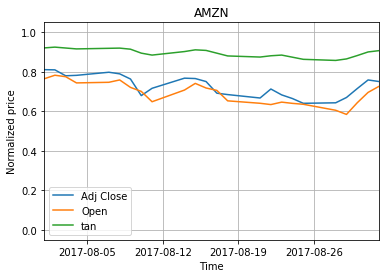

In [5]:
plt.plot(df['Adj Close'])
plt.plot(df['Open'])
plt.plot(df['tan'])
plt.grid()
plt.title(stock)
plt.xlabel('Time')
plt.ylabel('Normalized price')
plt.xlim([datetime(2017, 8, 1), datetime(2017, 9, 1)])
plt.legend()
plt.show()

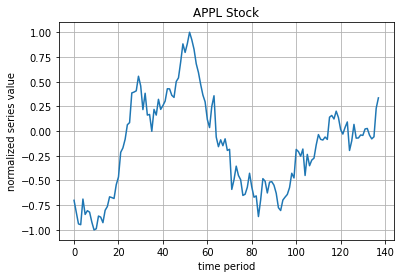

In [2]:
# lets take a look at our time series
plt.plot(dataset)
plt.grid()
plt.xlabel('time period')
plt.ylabel('normalized series value')
plt.title('APPL Stock')

## 1.2  Cutting our time series into sequences

Remember, our time series is a sequence of numbers that we can represent in general mathematically as 

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="images/timeseries_windowing_training.gif" width=600 height=600/>

For example - using a window of size T = 5 (as illustrated in the gif above) we produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice here that each input is a sequence (or vector) of length 5 (and in general has length equal to the window size T) while each corresponding output is a scalar value.  Notice also how given a time series of length P and window size T = 5 as shown above, we created P - 5  input/output pairs.  More generally, for a window size T we create P - T such pairs.

Now its time for you to window the input time series as described above!  

<a id='TODO_1'></a>

**TODO:** Implement the function called **window_transform_series** in my_answers.py so that it runs a sliding window along the input series and creates associated input/output pairs.    Note that this function should input a) the series and b) the window length, and return the input/output subsequences.  Make sure to format returned input/output as generally shown in table above (where window_size = 5), and make sure your returned input is a numpy array.

-----

You can test your function on the list of odd numbers given below

In [3]:
odd_nums = np.array([1,3,5,7,9,11,13])

Here is a hard-coded solution for odd_nums.  You can compare its results with what you get from your **window_transform_series** implementation.

In [4]:
# run a window of size 2 over the odd number sequence and display the results
window_size = 2

X = []
X.append(odd_nums[0:2])
X.append(odd_nums[1:3])
X.append(odd_nums[2:4])
X.append(odd_nums[3:5])
X.append(odd_nums[4:6])

y = odd_nums[2:]

X_sample = np.asarray(X)
y = np.asarray(y)
y_sample = np.reshape(y, (len(y),1)) #optional

assert(type(X_sample).__name__ == 'ndarray')
assert(type(y_sample).__name__ == 'ndarray')
assert(X_sample.shape == (5,2))
assert(y_sample.shape in [(5,1), (5,)])

# print out input/output pairs --> here input = X, corresponding output = y
print ('--- the input X will look like ----')
print (X_sample)

print ('--- the associated output y will look like ----')
print (y_sample)

--- the input X will look like ----
[[ 1  3]
 [ 3  5]
 [ 5  7]
 [ 7  9]
 [ 9 11]]
--- the associated output y will look like ----
[[ 5]
 [ 7]
 [ 9]
 [11]
 [13]]


Again - you can check that your completed **window_transform_series** function works correctly by trying it on the odd_nums sequence - you should get the above output.

In [5]:
### TODO: implement the function window_transform_series in the file my_answers.py
from my_answers import window_transform_series
X_odd, y_odd = window_transform_series(odd_nums, 2)
assert np.array_equal(X_odd, X_sample)
assert np.array_equal(y_odd, y_sample)

With this function in place apply it to the series in the Python cell below.  We use a window_size = 7 for these experiments.

In [7]:
# window the data using your windowing function
window_size = 7
X,y = window_transform_series(series = dataset,window_size = window_size)
print('X shape: {}'.format(X.shape))
print('y shape: {}'.format(y.shape))

X shape: (131, 7)
y shape: (131, 1)


## 1.3  Splitting into training and testing sets

In order to perform proper testing on our dataset we will lop off the last 1/3 of it for validation (or testing).  This is that once we train our model we have something to test it on (like any regression problem!).  This splitting into training/testing sets is done in the cell below.

Note how here we are **not** splitting the dataset *randomly* as one typically would do when validating a regression model.  This is because our input/output pairs *are related temporally*.   We don't want to validate our model by training on a random subset of the series and then testing on another random subset, as this simulates the scenario that we receive new points *within the timeframe of our training set*.  

We want to train on one solid chunk of the series (in our case, the first full 2/3 of it), and validate on a later chunk (the last 1/3) as this simulates how we would predict *future* values of a time series.

In [10]:
# split our dataset into training / testing sets
train_test_split = int(np.ceil(2*len(y)/float(3)))   # set the split point
print('train_test_split: {}'.format(train_test_split))
# partition the training set
X_train = X[:train_test_split,:]
y_train = y[:train_test_split]

# keep the last chunk for testing
X_test = X[train_test_split:,:]
y_test = y[train_test_split:]

# NOTE: to use keras's RNN LSTM module our input must be reshaped to [samples, window size, stepsize] 
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))

print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

train_test_split: 88
X_train shape: (88, 7, 1)
y_train shape: (88, 1)
X_test shape: (43, 7, 1)
y_test shape: (43, 1)


<a id='TODO_2'></a>

## 1.4  Build and run an RNN regression model

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN.  We use Keras to quickly build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module with 5 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used (remember: we are performing regression here)

This can be constructed using just a few lines - see e.g., the [general Keras documentation](https://keras.io/getting-started/sequential-model-guide/) and the [LSTM documentation in particular](https://keras.io/layers/recurrent/) for examples of how to quickly use Keras to build neural network models.  Make sure you are initializing your optimizer given the [keras-recommended approach for RNNs](https://keras.io/optimizers/) 

(given in the cell below).  (remember to copy your completed function into the script *my_answers.py* function titled *build_part1_RNN* before submitting your project)

In [18]:
### TODO: create required RNN model
# import keras network libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import TensorBoard
import keras

# given - fix random seed - so we can all reproduce the same results on our default time series
np.random.seed(0)


# TODO: implement build_part1_RNN in my_answers.py
from my_answers import build_part1_RNN
model = build_part1_RNN(window_size)

# build model using keras documentation recommended optimizer initialization
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# compile the model
model.compile(loss='mean_squared_error', optimizer=optimizer)

# summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 5)                 140       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 146.0
Trainable params: 146
Non-trainable params: 0.0
_________________________________________________________________


With your model built you can now fit the model by activating the cell below!  Note: the number of epochs (np_epochs) and batch_size are preset (so we can all produce the same results).  You can choose to toggle the verbose parameter - which gives you regular updates on the progress of the algorithm - on and off by setting it to 1 or 0 respectively.

In [20]:
tensorBoard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

In [22]:
# run your model!
hist = model.fit(X_train, y_train, epochs=1000, batch_size=50, verbose=0, callbacks=[tensorBoard])

## 1.5  Checking model performance

With your model fit we can now make predictions on both our training and testing sets.

In [25]:
# generate predictions for training
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
print(train_predict.shape)
print(test_predict.shape)

(88, 1)
(43, 1)


In the next cell we compute training and testing errors using our trained model - you should be able to achieve at least

*training_error* < 0.02

and 

*testing_error* < 0.02

with your fully trained model.  

If either or both of your accuracies are larger than 0.02 re-train your model - increasing the number of epochs you take (a maximum of around 1,000 should do the job) and/or adjusting your batch_size.

In [16]:
# print out training and testing errors
training_error = model.evaluate(X_train, y_train, verbose=0)
print('training error = ' + str(training_error))

testing_error = model.evaluate(X_test, y_test, verbose=0)
print('testing error = ' + str(testing_error))

np.testing.assert_array_less(training_error, 0.02)
np.testing.assert_array_less(testing_error, 0.02)

training error = 0.0160045766018
testing error = 0.0139842450316


Activating the next cell plots the original data, as well as both predictions on the training and testing sets. 

In [26]:
train_predict[:10]

array([[-0.77144665],
       [-0.77918047],
       [-0.85535377],
       [-0.92449015],
       [-0.93034309],
       [-0.8350839 ],
       [-0.8334468 ],
       [-0.8679353 ],
       [-0.77209896],
       [-0.73227125]], dtype=float32)

In [27]:
y[:10]

array([[-0.82058073],
       [-0.92023124],
       [-1.        ],
       [-0.98814438],
       [-0.85961411],
       [-0.8706188 ],
       [-0.92661512],
       [-0.80118585],
       [-0.76288204],
       [-0.66499478]])

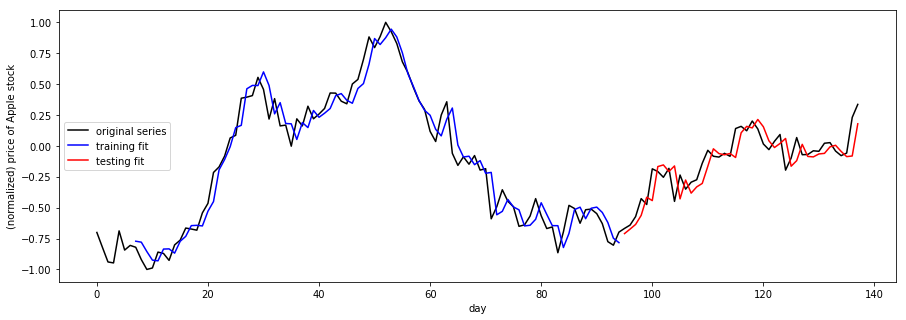

In [32]:
### Plot everything - the original series as well as predictions on training and testing sets
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(15, 5))
# plot original series
plt.plot(dataset,color = 'k')

# plot training set prediction
split_pt = train_test_split + window_size 
plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

# plot testing set prediction
plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('(normalized) price of Apple stock')
plt.legend(['original series','training fit','testing fit'],loc='center left')
plt.show()

**Note:** you can try out any time series for this exercise!  If you would like to try another see e.g., [this site containing thousands of time series](https://datamarket.com/data/list/?q=provider%3Atsdl) and pick another one!

# Problem 2: Create a sequence generator

## 2.1  Getting started

In this project you will implement a popular Recurrent Neural Network (RNN) architecture to create an English language sequence generator capable of building semi-coherent English sentences from scratch by building them up character-by-character.  This will require a substantial amount amount of parameter tuning on a large training corpus (at least 100,000 characters long).  In particular for this project we will be using a complete version of Sir Arthur Conan Doyle's classic book The Adventures of Sherlock Holmes.

How can we train a machine learning model to generate text automatically, character-by-character?  *By showing the model many training examples so it can learn a pattern between input and output.*  With this type of text generation each input is a string of valid characters like this one

*dogs are grea*

while the corresponding output is the next character in the sentence - which here is 't' (since the complete sentence is 'dogs are great').  We need to show a model many such examples in order for it to make reasonable predictions.

**Fun note:** For those interested in how text generation is being used check out some of the following fun resources:

- [Generate wacky sentences](http://www.cs.toronto.edu/~ilya/rnn.html) with this academic RNN text generator

- Various twitter bots that tweet automatically generated text like[this one](http://tweet-generator-alex.herokuapp.com/).

- the [NanoGenMo](https://github.com/NaNoGenMo/2016) annual contest to automatically produce a 50,000+ novel automatically

- [Robot Shakespeare](https://github.com/genekogan/RobotShakespeare) a text generator that automatically produces Shakespear-esk sentences

## 2.2  Preprocessing a text dataset

Our first task is to get a large text corpus for use in training, and on it we perform a several light pre-processing tasks.  The default corpus we will use is the classic book Sherlock Holmes, but you can use a variety of others as well - so long as they are fairly large (around 100,000 characters or more).  

In [2]:
# read in the text, transforming everything to lower case
text = open('datasets/holmes.txt').read().lower()
print('our original text has ' + str(len(text)) + ' characters')
uni = len(set(text))
print('Unique chars: {}'.format(uni))

our original text has 581864 characters
Unique chars: 63


Next, lets examine a bit of the raw text.  Because we are interested in creating sentences of English words automatically by building up each word character-by-character, we only want to train on valid English words.  In other words - we need to remove all of the other characters that are not part of English words.

In [3]:
### print out the first 1000 characters of the raw text to get a sense of what we need to throw out
text[:2000]

"\ufeffproject gutenberg's the adventures of sherlock holmes, by arthur conan doyle\n\nthis ebook is for the use of anyone anywhere at no cost and with\nalmost no restrictions whatsoever.  you may copy it, give it away or\nre-use it under the terms of the project gutenberg license included\nwith this ebook or online at www.gutenberg.net\n\n\ntitle: the adventures of sherlock holmes\n\nauthor: arthur conan doyle\n\nposting date: april 18, 2011 [ebook #1661]\nfirst posted: november 29, 2002\n\nlanguage: english\n\n\n*** start of this project gutenberg ebook the adventures of sherlock holmes ***\n\n\n\n\nproduced by an anonymous project gutenberg volunteer and jose menendez\n\n\n\n\n\n\n\n\n\nthe adventures of sherlock holmes\n\nby\n\nsir arthur conan doyle\n\n\n\n   i. a scandal in bohemia\n  ii. the red-headed league\n iii. a case of identity\n  iv. the boscombe valley mystery\n   v. the five orange pips\n  vi. the man with the twisted lip\n vii. the adventure of the blue carbuncle\nvii

Wow - there's a lot of junk here (i.e., weird uncommon character combinations - as this first character chunk contains the title and author page, as well as table of contents)!  To keep things simple, we want to train our RNN on a large chunk of more typical English sentences - we don't want it to start thinking non-english words or strange characters are valid! - so lets clean up the data a bit.

First, since the dataset is so large and the first few hundred characters contain a lot of junk, lets cut it out.  Lets also find-and-replace those newline tags with empty spaces.

In [4]:
### find and replace '\n' and '\r' symbols - replacing them 
text = text[1300:]
text = text.replace('\n',' ')    # replacing '\n' with '' simply removes the sequence
text = text.replace('\r',' ')

Lets see how the first 1000 characters of our text looks now!

In [5]:
### print out the first 1000 characters of the raw text to get a sense of what we need to throw out
text[:1000]

" his eyes she eclipses and predominates the whole of her sex. it was not that he felt any emotion akin to love for irene adler. all emotions, and that one particularly, were abhorrent to his cold, precise but admirably balanced mind. he was, i take it, the most perfect reasoning and observing machine that the world has seen, but as a lover he would have placed himself in a false position. he never spoke of the softer passions, save with a gibe and a sneer. they were admirable things for the observer--excellent for drawing the veil from men's motives and actions. but for the trained reasoner to admit such intrusions into his own delicate and finely adjusted temperament was to introduce a distracting factor which might throw a doubt upon all his mental results. grit in a sensitive instrument, or a crack in one of his own high-power lenses, would not be more disturbing than a strong emotion in a nature such as his. and yet there was but one woman to him, and that woman was the late irene

<a id='TODO_3'></a>

#### TODO: finish cleaning the text

Lets make sure we haven't left any other atypical characters (commas, periods, etc., are ok) lurking around in the depths of the text.  You can do this by enumerating all the text's unique characters, examining them, and then replacing any unwanted characters with empty spaces!  Once we find all of the text's unique characters, we can remove all of the atypical ones in the next cell.  Note: don't remove the punctuation marks given in my_answers.py.

In [6]:
### TODO: implement cleaned_text in my_answers.py
from my_answers import cleaned_text
print('Text elements: {}'.format(len(text)))
text = cleaned_text(text)
# shorten any extra dead space created above
text = text.replace('  ',' ')
print('Text after removing all ascii elements: {}'.format(len(text)))

Text elements: 580564
Text after removing all ascii elements: 573681


With your chosen characters removed print out the first few hundred lines again just to double check that everything looks good.

In [7]:
### print out the first 2000 characters of the raw text to get a sense of what we need to throw out
text[:2000]

'his eyes she eclipses and predominates the whole of her sex. it was not that he felt any emotion akin to love for irene adler. all emotions, and that one particularly, were abhorrent to his cold, precise but admirably balanced mind. he was, i take it, the most perfect reasoning and observing machine that the world has seen, but as a lover he would have placed himself in a false position. he never spoke of the softer passions, save with a gibe and a sneer. they were admirable things for the observer excellent for drawing the veil from men s motives and actions. but for the trained reasoner to admit such intrusions into his own delicate and finely adjusted temperament was to introduce a distracting factor which might throw a doubt upon all his mental results. grit in a sensitive instrument, or a crack in one of his own high power lenses, would not be more disturbing than a strong emotion in a nature such as his. and yet there was but one woman to him, and that woman was the late irene a

Now that we have thrown out a good number of non-English characters/character sequences lets print out some statistics about the dataset - including number of total characters and number of unique characters.

In [8]:
# count the number of unique characters in the text
chars = sorted(list(set(text)))

# print some of the text, as well as statistics
print ("this corpus has " +  str(len(text)) + " total number of characters")
print ("this corpus has " +  str(len(chars)) + " unique characters")

this corpus has 573681 total number of characters
this corpus has 33 unique characters


## 2.3  Cutting data into input/output pairs

Now that we have our text all cleaned up, how can we use it to train a model to generate sentences automatically?  First we need to train a machine learning model - and in order to do that we need a set of input/output pairs for a model to train on.  How can we create a set of input/output pairs from our text to train on?

Remember in part 1 of this notebook how we used a sliding window to extract input/output pairs from a time series?  We do the same thing here!  We slide a window of length $T$ along our giant text corpus - everything in the window becomes one input while the character following becomes its corresponding output.  This process of extracting input/output pairs is illustrated in the gif below on a small example text using a window size of T = 5.

<img src="images/text_windowing_training.gif" width=400 height=400/>

Notice one aspect of the sliding window in this gif that does not mirror the analogous gif for time series shown in part 1 of the notebook - we do not need to slide the window along one character at a time but can move by a fixed step size $M$ greater than 1 (in the gif indeed $M = 1$).  This is done with large input texts (like ours which has over 500,000 characters!) when sliding the window along one character at a time we would create far too many input/output pairs to be able to reasonably compute with.

More formally lets denote our text corpus - which is one long string of characters - as follows

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $P$ is the length of the text (again for our text $P \approx 500,000!$).  Sliding a window of size T = 5 with a step length of M = 1 (these are the parameters shown in the gif above) over this sequence produces the following list of input/output pairs


$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice here that each input is a sequence (or vector) of 5 characters (and in general has length equal to the window size T) while each corresponding output is a single character.  We created around P total number of input/output pairs  (for general step size M we create around ceil(P/M) pairs).

<a id='TODO_4'></a>

Now its time for you to window the input time series as described above! 

**TODO:** Create a function that runs a sliding window along the input text and creates associated input/output pairs.  A skeleton function has been provided for you.  Note that this function should input a) the text  b) the window size and c) the step size, and return the input/output sequences.  Note: the return items should be *lists* - not numpy arrays.

(remember to copy your completed function into the script *my_answers.py* function titled *window_transform_text* before submitting your project)

In [9]:
### TODO: implement window_transform_series in my_answers.py
from my_answers import window_transform_series

With our function complete we can now use it to produce input/output pairs!  We employ the function in the next cell, where the window_size = 50 and step_size = 5.

In [10]:
# run your text window-ing function 
window_size = 100
step_size = 5
inputs, outputs = window_transform_text(text,window_size,step_size)

Lets print out a few input/output pairs to verify that we have made the right sort of stuff!

In [11]:
# print out a few of the input/output pairs to verify that we've made the right kind of stuff to learn from
print('input = ' + inputs[2])
print('output = ' + outputs[2])
print('--------------')
print('input = ' + inputs[100])
print('output = ' + outputs[100])

input = he eclipses and predominates the whole of her sex. it was not that he felt any emotion akin to love 
output = f
--------------
input = ver excellent for drawing the veil from men s motives and actions. but for the trained reasoner to a
output = d


Looks good!

## 2.4  Wait, what kind of problem is text generation again?

In part 1 of this notebook we used the same pre-processing technique - the sliding window - to produce a set of training input/output pairs to tackle the problem of time series prediction *by treating the problem as one of regression*.  So what sort of problem do we have here now, with text generation?  Well, the time series prediction was a regression problem because the output (one value of the time series) was a continuous value.  Here - for character-by-character text generation - each output is a *single character*.  This isn't a continuous value - but a distinct class - therefore **character-by-character text generation is a classification problem**.  

How many classes are there in the data?  Well, the number of classes is equal to the number of unique characters we have to predict!  How many of those were there in our dataset again?  Lets print out the value again.

In [12]:
# print out the number of unique characters in the dataset
chars = sorted(list(set(text)))
print ("this corpus has " +  str(len(chars)) + " unique characters")
print ('and these characters are ')
print (chars)

this corpus has 33 unique characters
and these characters are 
[' ', '!', ',', '.', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Rockin' - so we have a multiclass classification problem on our hands!

## 2.5  One-hot encoding characters

The last issue we have to deal with is representing our text data as numerical data so that we can use it as an input to a neural network. One of the conceptually simplest ways of doing this is via a 'one-hot encoding' scheme.  Here's how it works.

We transform each character in our inputs/outputs into a vector with length equal to the number of unique characters in our text.  This vector is all zeros except one location where we place a 1 - and this location is unique to each character type.  e.g., we transform 'a', 'b', and 'c' as follows

$$a\longleftarrow\left[\begin{array}{c}
1\\
0\\
0\\
\vdots\\
0\\
0
\end{array}\right]\,\,\,\,\,\,\,b\longleftarrow\left[\begin{array}{c}
0\\
1\\
0\\
\vdots\\
0\\
0
\end{array}\right]\,\,\,\,\,c\longleftarrow\left[\begin{array}{c}
0\\
0\\
1\\
\vdots\\
0\\
0 
\end{array}\right]\cdots$$

where each vector has 32 entries (or in general: number of entries = number of unique characters in text).

The first practical step towards doing this one-hot encoding is to form a dictionary mapping each unique character to a unique integer, and one dictionary to do the reverse mapping.  We can then use these dictionaries to quickly make our one-hot encodings, as well as re-translate (from integers to characters) the results of our trained RNN classification model.

In [13]:
# this dictionary is a function mapping each unique character to a unique integer
chars_to_indices = dict((c, i) for i, c in enumerate(chars))  # map each unique character to unique integer

# this dictionary is a function mapping each unique integer back to a unique character
indices_to_chars = dict((i, c) for i, c in enumerate(chars))  # map each unique integer back to unique character

Now we can transform our input/output pairs - consisting of characters - to equivalent input/output pairs made up of one-hot encoded vectors.  In the next cell we provide a function for doing just this: it takes in the raw character input/outputs and returns their numerical versions.  In particular the numerical input is given as $\bf{X}$, and numerical output is given as the $\bf{y}$

In [14]:
# transform character-based input/output into equivalent numerical versions
def encode_io_pairs(text,window_size,step_size):
    # number of unique chars
    chars = sorted(list(set(text)))
    num_chars = len(chars)
    
    # cut up text into character input/output pairs
    inputs, outputs = window_transform_text(text,window_size,step_size)
    
    # create empty vessels for one-hot encoded input/output
    X = np.zeros((len(inputs), window_size, num_chars), dtype=np.bool)
    y = np.zeros((len(inputs), num_chars), dtype=np.bool)
    
    # loop over inputs/outputs and transform and store in X/y
    for i, sentence in enumerate(inputs):
        for t, char in enumerate(sentence):
            X[i, t, chars_to_indices[char]] = 1
        y[i, chars_to_indices[outputs[i]]] = 1
        
    return X,y

Now run the one-hot encoding function by activating the cell below and transform our input/output pairs!

In [15]:
# use your function
window_size = 100
step_size = 5
X,y = encode_io_pairs(text,window_size,step_size)

In [16]:
print(X.shape)
print(y.shape)

np.testing.assert_almost_equal(X.shape[0], len(inputs))

(114717, 100, 33)
(114717, 33)


<a id='TODO_5'></a>

## 2.6 Setting up our RNN

With our dataset loaded and the input/output pairs extracted / transformed we can now begin setting up our RNN for training.  Again we will use Keras to quickly build a single hidden layer RNN - where our hidden layer consists of LSTM modules.

Time to get to work: build a 3 layer RNN model of the following specification

- layer 1 should be an LSTM module with 200 hidden units --> note this should have input_shape = (window_size,len(chars)) where len(chars) = number of unique characters in your cleaned text
- layer 2 should be a linear module, fully connected, with len(chars) hidden units --> where len(chars) = number of unique characters in your cleaned text
- layer 3 should be a softmax activation ( since we are solving a *multiclass classification*)
- Use the **categorical_crossentropy** loss 

This network can be constructed using just a few lines - as with the RNN network you made in part 1 of this notebook.  See e.g., the [general Keras documentation](https://keras.io/getting-started/sequential-model-guide/) and the [LSTM documentation in particular](https://keras.io/layers/recurrent/) for examples of how to quickly use Keras to build neural network models.

In [17]:
### necessary functions from the keras library
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import keras
import random

# TODO implement build_part2_RNN in my_answers.py
from my_answers import build_part2_RNN

model = build_part2_RNN(window_size, len(chars))

# initialize optimizer
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# compile model --> make sure initialized optimizer and callbacks - as defined above - are used
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

# model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               187200    
_________________________________________________________________
dense_1 (Dense)              (None, 33)                6633      
_________________________________________________________________
activation_1 (Activation)    (None, 33)                0         
Total params: 193,833.0
Trainable params: 193,833.0
Non-trainable params: 0.0
_________________________________________________________________


## 2.7  Training our RNN model for text generation

With our RNN setup we can now train it!  Lets begin by trying it out on a small subset of the larger version.  In the next cell we take the first 10,000 input/output pairs from our training database to learn on.

In [34]:
# a small subset of our input/output pairs
Xsmall = X[:10000,:,:]
ysmall = y[:10000,:]

Now lets fit our model!

In [35]:
# train the model
model.fit(Xsmall, ysmall, batch_size=256, epochs=40,verbose = 1)

# save weights
model.save_weights('model_weights/best_RNN_small_textdata_weights.hdf5')

Epoch 1/40
10000/10000 [==============================] - 4s - loss: 2.9741     
Epoch 2/40
10000/10000 [==============================] - 4s - loss: 2.8680     
Epoch 3/40
10000/10000 [==============================] - 4s - loss: 2.8032     
Epoch 4/40
10000/10000 [==============================] - 4s - loss: 2.6957     
Epoch 5/40
10000/10000 [==============================] - 4s - loss: 2.5822     
Epoch 6/40
10000/10000 [==============================] - 4s - loss: 2.4960     
Epoch 7/40
10000/10000 [==============================] - 4s - loss: 2.4326     
Epoch 8/40
10000/10000 [==============================] - 4s - loss: 2.3819     
Epoch 9/40
10000/10000 [==============================] - 4s - loss: 2.3379     
Epoch 10/40
10000/10000 [==============================] - 4s - loss: 2.2969     
Epoch 11/40
10000/10000 [==============================] - 4s - loss: 2.2677     
Epoch 12/40
10000/10000 [==============================] - 4s - loss: 2.2359     
Epoch 13/40
10000/10000 [

How do we make a given number of predictions (characters) based on this fitted model?   

First we predict the next character after following any chunk of characters in the text of length equal to our chosen window size.  Then we remove the first character in our input sequence and tack our prediction onto the end.  This gives us a slightly changed sequence of inputs that still has length equal to the size of our window.  We then feed in this updated input sequence into the model to predict the another character.  Together then we have two predicted characters following our original input sequence.  Repeating this process N times gives us N predicted characters.

In the next Python cell we provide you with a completed function that does just this - it makes predictions when given a) a trained RNN model, b) a subset of (window_size) characters from the text, and c) a number of characters to predict (to follow our input subset).

In [20]:
# function that uses trained model to predict a desired number of future characters
def predict_next_chars(model,input_chars,num_to_predict):     
    # create output
    predicted_chars = ''
    for i in range(num_to_predict):
        # convert this round's predicted characters to numerical input    
        x_test = np.zeros((1, window_size, len(chars)))
        for t, char in enumerate(input_chars):
            x_test[0, t, chars_to_indices[char]] = 1.

        # make this round's prediction
        test_predict = model.predict(x_test,verbose = 0)[0]

        # translate numerical prediction back to characters
        r = np.argmax(test_predict)                           # predict class of each test input
        d = indices_to_chars[r] 

        # update predicted_chars and input
        predicted_chars+=d
        input_chars+=d
        input_chars = input_chars[1:]
    return predicted_chars

<a id='TODO_6'></a>

With your trained model try a few subsets of the complete text as input - note the length of each must be exactly equal to the window size.  For each subset use the function above to predict the next 100 characters that follow each input.

In [37]:
text[11000:11100]

'moment, for his hand was still raised to it as he entered. from the lower part of the face he appear'

In [38]:
# TODO: choose an input sequence and use the prediction function in the previous Python cell to predict 100 characters following it
# get an appropriately sized chunk of characters from the text
start_inds = [chars_to_indices[i] for i in text[11000:11100]]
assert len(start_inds) == 100
# load in weights
model.load_weights('model_weights/best_RNN_small_textdata_weights.hdf5')
for s in start_inds:
    start_index = s
    input_chars = text[start_index: start_index + window_size]

    # use the prediction function
    predict_input = predict_next_chars(model,input_chars,num_to_predict = 100)

    # print out input characters
    print('------------------')
    input_line = 'input chars = ' + '\n' +  input_chars + '"' + '\n'
    print(input_line)

    # print out predicted characters
    line = 'predicted chars = ' + '\n' +  predict_input + '"' + '\n'
    print(line)

------------------
input chars = 
es and predominates the whole of her sex. it was not that he felt any emotion akin to love for irene"

predicted chars = 
s of the touthe was shall the sed wound dout how she there the shas of the stinet whot ho mand you t"

------------------
input chars = 
 and predominates the whole of her sex. it was not that he felt any emotion akin to love for irene a"

predicted chars = 
nd oures is ou the tount whit she the lout hou d on the tout shas how he dout an the lloked good his"

------------------
input chars = 
es and predominates the whole of her sex. it was not that he felt any emotion akin to love for irene"

predicted chars = 
s of the touthe was shall the sed wound dout how she there the shas of the stinet whot ho mand you t"

------------------
input chars = 
e eclipses and predominates the whole of her sex. it was not that he felt any emotion akin to love f"

predicted chars = 
ore the stomen was a mas lofe ingen the hasked to thas hook howhend

------------------
input chars = 
s she eclipses and predominates the whole of her sex. it was not that he felt any emotion akin to lo"

predicted chars = 
me.  of the there of the stone whom she laye have shed hos how ho day you mad tooke. hes selled the "

------------------
input chars = 
lipses and predominates the whole of her sex. it was not that he felt any emotion akin to love for i"

predicted chars = 
nge soull tooked howmes.  beat herledted how she looked hood she hooked the shall hood the haster th"

------------------
input chars = 
 predominates the whole of her sex. it was not that he felt any emotion akin to love for irene adler"

predicted chars = 
. out so ming you mas hourd in how the touth who has anded the goon how he dout and the logen hous s"

------------------
input chars = 
e eclipses and predominates the whole of her sex. it was not that he felt any emotion akin to love f"

predicted chars = 
ore the stomen was a mas lofe ingen the hasked to thas hook howhend

------------------
input chars = 
predominates the whole of her sex. it was not that he felt any emotion akin to love for irene adler."

predicted chars = 
 out so ming you mas hourd in how the touth who has anded the goon how he dout and the logen hous sh"

------------------
input chars = 
clipses and predominates the whole of her sex. it was not that he felt any emotion akin to love for "

predicted chars = 
or the lomen wall the serentores has some houd the hastere was shall the the look how shed tote the "

------------------
input chars = 
e eclipses and predominates the whole of her sex. it was not that he felt any emotion akin to love f"

predicted chars = 
ore the stomen was a mas lofe ingen the hasked to thas hook howhend the wall yout se goun the than a"

------------------
input chars = 
his eyes she eclipses and predominates the whole of her sex. it was not that he felt any emotion aki"

predicted chars = 
nge the looked hooked he made the that hoom holled to engerto dout 

------------------
input chars = 
and predominates the whole of her sex. it was not that he felt any emotion akin to love for irene ad"

predicted chars = 
ly of the then of the stane and as all of the shestowe hous doud the was and of the stonked wholl no"

------------------
input chars = 
e eclipses and predominates the whole of her sex. it was not that he felt any emotion akin to love f"

predicted chars = 
ore the stomen was a mas lofe ingen the hasked to thas hook howhend the wall yout se goun the than a"

------------------
input chars = 
s she eclipses and predominates the whole of her sex. it was not that he felt any emotion akin to lo"

predicted chars = 
me.  of the there of the stone whom she laye have shed hos how ho day you mad tooke. hes selled the "

------------------
input chars = 
d predominates the whole of her sex. it was not that he felt any emotion akin to love for irene adle"

predicted chars = 
 ofrested but the thentor whill anderered the pooke the shang how s

This looks ok, but not great.  Now lets try the same experiment with a larger chunk of the data - with the first 100,000 input/output pairs.  

Tuning RNNs for a typical character dataset like the one we will use here is a computationally intensive endeavour and thus timely on a typical CPU.  Using a reasonably sized cloud-based GPU can speed up training by a factor of 10.  Also because of the long training time it is highly recommended that you carefully write the output of each step of your process to file.  This is so that all of your results are saved even if you close the web browser you're working out of, as the processes will continue processing in the background but variables/output in the notebook system will not update when you open it again.

In the next cell we show you how to create a text file in Python and record data to it.  This sort of setup can be used to record your final predictions.

In [39]:
### A simple way to write output to file
f = open('my_test_output.txt', 'w')              # create an output file to write too
f.write('this is only a test ' + '\n')           # print some output text
x = 2
f.write('the value of x is ' + str(x) + '\n')    # record a variable value
f.close()     

# print out the contents of my_test_output.txt
f = open('my_test_output.txt', 'r')              # create an output file to write too
f.read()

'this is only a test \nthe value of x is 2\n'

With this recording devices we can now more safely perform experiments on larger portions of the text.  In the next cell we will use the first 100,000 input/output pairs to train our RNN model.

First we fit our model to the dataset, then generate text using the trained model in precisely the same generation method applied before on the small dataset.

**Note:** your generated words should be - by and large - more realistic than with the small dataset, but you won't be able to generate perfect English sentences even with this amount of data.  A rule of thumb: your model is working well if you generate sentences that largely contain real English words.

In [40]:
# a small subset of our input/output pairs
Xlarge = X[:100000,:,:]
ylarge = y[:100000,:]

# TODO: fit to our larger dataset
model.fit(Xlarge, ylarge, batch_size=500, epochs=50, verbose=1)

# save weights
model.save_weights('model_weights/best_RNN_large_textdata_weights.hdf5')

Epoch 1/50
100000/100000 [==============================] - 36s - loss: 1.9804    
Epoch 2/50
100000/100000 [==============================] - 37s - loss: 1.8739    
Epoch 3/50
100000/100000 [==============================] - 37s - loss: 1.8120    
Epoch 4/50
100000/100000 [==============================] - 37s - loss: 1.7614    
Epoch 5/50
100000/100000 [==============================] - 37s - loss: 1.7168    
Epoch 6/50
100000/100000 [==============================] - 37s - loss: 1.6765    
Epoch 7/50
100000/100000 [==============================] - 37s - loss: 1.6381    
Epoch 8/50
100000/100000 [==============================] - 37s - loss: 1.6023    
Epoch 9/50
100000/100000 [==============================] - 37s - loss: 1.5689    
Epoch 10/50
100000/100000 [==============================] - 37s - loss: 1.5347    
Epoch 11/50
100000/100000 [==============================] - 37s - loss: 1.5021    
Epoch 12/50
100000/100000 [==============================] - 37s - loss: 1.4698    
E

In [41]:
# TODO: choose an input sequence and use the prediction function in the previous Python cell to predict 100 characters following it
# get an appropriately sized chunk of characters from the text
start_inds = [chars_to_indices[i] for i in text[200000:200100]]
assert len(start_inds) == 100
# save output
f = open('text_gen_output/RNN_large_textdata_output.txt', 'w')  # create an output file to write too

# load weights
model.load_weights('model_weights/best_RNN_large_textdata_weights.hdf5')
for s in start_inds:
    start_index = s
    input_chars = text[start_index: start_index + window_size]

    # use the prediction function
    predict_input = predict_next_chars(model,input_chars,num_to_predict = 100)

    # print out input characters
    line = '-------------------' + '\n'
    print(line)
    f.write(line)

    input_line = 'input chars = ' + '\n' +  input_chars + '"' + '\n'
    print(input_line)
    f.write(input_line)

    # print out predicted characters
    predict_line = 'predicted chars = ' + '\n' +  predict_input + '"' + '\n'
    print(predict_line)
    f.write(predict_line)
f.close()

-------------------

input chars = 
e eclipses and predominates the whole of her sex. it was not that he felt any emotion akin to love f"

predicted chars = 
ormidid to me. he refalded as a right of the many a few moners is the elpoop of the time.  and she p"

-------------------

input chars = 
s eyes she eclipses and predominates the whole of her sex. it was not that he felt any emotion akin "

predicted chars = 
the there were started his atter. in this was lecked to her open. he wouldned go an and that if thee"

-------------------

input chars = 
his eyes she eclipses and predominates the whole of her sex. it was not that he felt any emotion aki"

predicted chars = 
ng the reflick, which was chair to the ressins of the ger of st. sill.  i am a lattle stroke offer t"

-------------------

input chars = 
s she eclipses and predominates the whole of her sex. it was not that he felt any emotion akin to lo"

predicted chars = 
ok it was discancerive i mad the plaie my from here, and he

-------------------

input chars = 
s she eclipses and predominates the whole of her sex. it was not that he felt any emotion akin to lo"

predicted chars = 
ok it was discancerive i mad the plaie my from here, and he had strreffffrey nave a shall be an and "

-------------------

input chars = 
lipses and predominates the whole of her sex. it was not that he felt any emotion akin to love for i"

predicted chars = 
t?  well, she is not not been and to hight that the could not doubfut with a thinger of his contries"

-------------------

input chars = 
s and predominates the whole of her sex. it was not that he felt any emotion akin to love for irene "

predicted chars = 
in the miness which he had been diep have and down to at his fain. her as the fllight, with a pack i"

-------------------

input chars = 
his eyes she eclipses and predominates the whole of her sex. it was not that he felt any emotion aki"

predicted chars = 
ng the reflick, which was chair to the ressins of the ger o

-------------------

input chars = 
his eyes she eclipses and predominates the whole of her sex. it was not that he felt any emotion aki"

predicted chars = 
ng the reflick, which was chair to the ressins of the ger of st. sill.  i am a lattle stroke offer t"

-------------------

input chars = 
dominates the whole of her sex. it was not that he felt any emotion akin to love for irene adler. al"

predicted chars = 
d it was think noth and that if i have a sark with his ased the flanks when he was no into be noted."

-------------------

input chars = 
 and predominates the whole of her sex. it was not that he felt any emotion akin to love for irene a"

predicted chars = 
nd then there is a littee with his faie, as i have an i rasher the  that i was enter a reasted of ev"

-------------------

input chars = 
edominates the whole of her sex. it was not that he felt any emotion akin to love for irene adler. a"

predicted chars = 
nd let me a pry of and fingest anoling of the suddenagain, 

-------------------

input chars = 
predominates the whole of her sex. it was not that he felt any emotion akin to love for irene adler."

predicted chars = 
 on the bed of my said from the eaters a dowe surdes. the one this his was through me wish and flent"

-------------------

input chars = 
e eclipses and predominates the whole of her sex. it was not that he felt any emotion akin to love f"

predicted chars = 
ormidid to me. he refalded as a right of the many a few moners is the elpoop of the time.  and she p"

-------------------

input chars = 
d predominates the whole of her sex. it was not that he felt any emotion akin to love for irene adle"

predicted chars = 
t.  nery dee. we see that he had strongrat lef thin s that a ster conforraty ond the ere of the door"

-------------------

input chars = 
his eyes she eclipses and predominates the whole of her sex. it was not that he felt any emotion aki"

predicted chars = 
ng the reflick, which was chair to the ressins of the ger o

In [18]:
# a small subset of our input/output pairs
Xfull = X
yfull = y

# TODO: fit to our larger dataset
model.fit(Xfull, yfull, batch_size=512, epochs=50, verbose=1)

# save weights
model.save_weights('model_weights/best_RNN_full_textdata_weights.hdf5')

Epoch 1/50
114717/114717 [==============================] - 40s - loss: 2.6931    
Epoch 2/50
114717/114717 [==============================] - 40s - loss: 2.2715    
Epoch 3/50
114717/114717 [==============================] - 41s - loss: 2.1194    
Epoch 4/50
114717/114717 [==============================] - 40s - loss: 2.0153    
Epoch 5/50
114717/114717 [==============================] - 40s - loss: 1.9364    
Epoch 6/50
114717/114717 [==============================] - 39s - loss: 1.8727    
Epoch 7/50
114717/114717 [==============================] - 40s - loss: 1.8174    
Epoch 8/50
114717/114717 [==============================] - 40s - loss: 1.7696    
Epoch 9/50
114717/114717 [==============================] - 40s - loss: 1.7261    
Epoch 10/50
114717/114717 [==============================] - 40s - loss: 1.6858    
Epoch 11/50
114717/114717 [==============================] - 40s - loss: 1.6490    
Epoch 12/50
114717/114717 [==============================] - 40s - loss: 1.6150    
E

In [26]:
start_inds = [chars_to_indices[i] for i in text[200000:200100]]
assert len(start_inds) == 100
# save output
f = open('text_gen_output/RNN_full_textdata_output.txt', 'w')  # create an output file to write too

# load weights
model.load_weights('model_weights/best_RNN_full_textdata_weights.hdf5')
for s in start_inds:
    start_index = s
    input_chars = text[start_index: start_index + window_size]

    # use the prediction function
    predict_input = predict_next_chars(model,input_chars,num_to_predict = 100)

    # print out input characters
    line = '-------------------' + '\n'
    f.write(line)
    input_line = 'input chars = ' + '\n' +  input_chars + '"' + '\n'
    f.write(input_line)
    # print out predicted characters
    predict_line = 'predicted chars = ' + '\n' +  predict_input + '"' + '\n'
    f.write(predict_line)

f.close()